The curve below is part of a family of $C^2$, nonself-intersecting curves whose limit is surjective on the equilateral triangle. 

In [1]:
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import puncturedfem as pf

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate

#accepts the vertices of a triangle to find the coordinates of a space filling curve
def SFC(A,B,C,n,p):
    #switch on the top 2 bits of n. 
    if p==0:
        return [2*A/3+(A+B+C)/9,2*(A/6+2*B/3+C/6)/3+(A+B+C)/9,2*C/3+(A+B+C)/9]
    match n>>2*(p-1) & 3:
        case 0:
            return SFC(A,(A+C)/2,(A+B)/2,n,p-1)
        case 1:
            return SFC((A+B)/2,B,(C+B)/2,n,p-1)
        case 2:
            return SFC((B+C)/2,(A+B)/2,(A+C)/2,n,p-1)
        case 3:
            return SFC((A+C)/2,(B+C)/2,C,n,p-1)
        
family_param=1
idxs=np.arange(3*4**family_param)
A=np.array([0,0])
B=np.array([1.0/2,np.sqrt(3)/2])
C=np.array([1,0])
D=(A+B+C)/3
A_=(1-1/4**family_param)*A+1/4**family_param*D
B_=(1-1/4**family_param)*B+1/4**family_param*D
C_=(1-1/4**family_param)*C+1/4**family_param*D
def myfun_x(n):
    return SFC(A_,B_,C_,n//3,family_param)[n%3][0]
def myfun_y(n):
    return SFC(A_,B_,C_,n//3,family_param)[n%3][1]
xs = np.append([0,A_[0]],np.append(np.array([myfun_x(n) for n in idxs]),[C_[0],1]))
ys = np.append([0,0],np.append(np.array([myfun_y(n) for n in idxs]),[0,0]))

#tck,u= interpolate.splprep([xs,ys],s=0)

## Construct the mesh cell


In [2]:
vA=pf.Vert(0,0,0)
vB=pf.Vert(1/2,np.sqrt(3)/2,1)
vC=pf.Vert(1,0,2)
edges = [
    pf.Edge(vA,vC,curve_type="spline", pos_cell_idx=0, idx=0, pts=[xs,ys]),
    pf.Edge(vC,vB,pos_cell_idx=0, idx=1),
    pf.Edge(vB,vA,pos_cell_idx=0, idx=2)
]

With the edges defined, let's make the mesh cell $K$.

In [3]:
K = pf.MeshCell(idx=0, edges=edges)
print(K.get_edges()[0].curve_type)

spline


Let's parameterize the edges, and plot the edges to check that we have what we 
want.

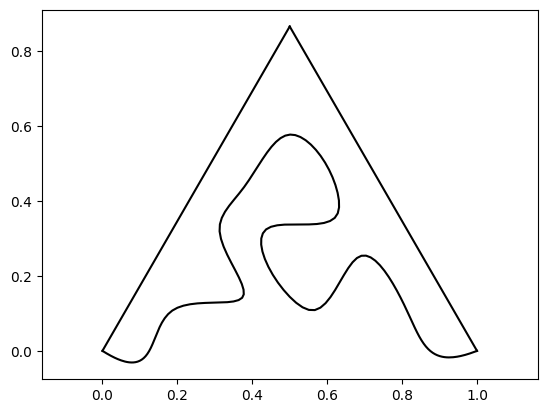

In [4]:
quad_dict = pf.get_quad_dict(n=128,p=7)
K.parameterize(quad_dict)
pf.plot.MeshPlot(K.get_edges()).draw()

## Build local Poisson space
With the mesh cell $K$ defined, we are prepared to construct the local Poisson
space $V_p(K)$.
The polynomial degree $p$ is specified by the user by passing the `deg`
keyword argument to the `LocalPoissonSpace` constructor.

Depending on the degree and the edge discretization parameter `n` we chose 
above, this may take a couple of minutes.

In [5]:
V = pf.LocalFunctionSpace(K, deg=1)

Setting up Nyström Solver... 768 sampled points on 3 Edges
Computing function metadata...


100%|██████████| 4/4 [00:00<00:00,  9.18it/s]


Finding interior values...


100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


It holds that the dimension of the local Poisson space is given by 
$$
    \dim V_p(K) = {p \choose 2}
    -|E(\partial K)|
    + \sum_{e \in E(\partial K)} \dim \mathbb{P}_p(e)
$$
where $E(\partial K)$ is the set of edges of the boundary of $K$,
and $\dim \mathbb{P}_p(e)$ is the dimension of the *edge space* on $e$,
consisting of traces of polynomials of degree at most $p$ on $e$.
The dimension of this edge space depends on the nature of the edge $e$.
In our case, each edge of the boundary is a line segment, so
$$
    \dim \mathbb{P}_p(e) = p + 1
$$
so we have
$$
    \dim V_p(K) = {p \choose 2} + p \, \underbrace{|E(\partial K)|}_{=13}.
$$
Here is a table of the dimensions of the local Poisson spaces for the first
few values of $p$.

| $p$ | $\dim V_p(K)$ |
| --- | --- |
| 1 | 13 |
| 2 | 27 |
| 3 | 42 |

Let's verify that the dimension of the local Poisson space is what we expect.

In [6]:
print(f"polynomial degree: p = {V.deg}")
print(f"number of edges: {K.num_edges}")
print(f"dim(V_{V.deg}(K)) = {V.num_funs}")

polynomial degree: p = 1
number of edges: 3
dim(V_1(K)) = 4


## Plot the basis functions
Let's plot the basis functions to see what they look like.

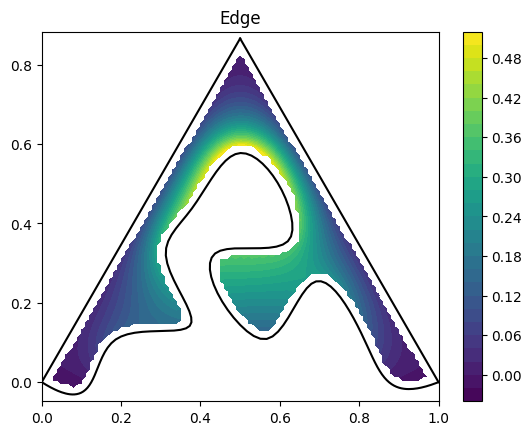

In [7]:
for v in V.edge_funs:
    pf.plot.LocalFunctionPlot(v).draw_vals(title=f"{v.key.fun_type}")